## _Building Graphs: True Edges_

- layerwise true edges
- modulewise true edges

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('..')

In [6]:
# local imports
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian
from src import Compose_Event, Draw_Compose_Event

### _(+) - Input Data_

In [7]:
# input data
input_dir = '../train_all'

In [8]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [9]:
# file_prefixes[:10]

In [10]:
event_id = 95191
event_prefix = file_prefixes[event_id]

In [11]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000095191 memory usage 0.04 MB


In [12]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,10.4962,-13.130,35.0,9,0,62
1,2,11.3709,-13.635,35.0,9,1,170
2,3,11.3709,-14.645,35.0,9,2,283
3,4,12.2456,-15.150,35.0,9,3,403
4,5,12.2456,-16.160,35.0,9,4,528


In [13]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.017837,6899980.0,6.89998,9,0,62,0,3
1,2,0.347309,4051070.0,4.05107,9,1,170,0,3
2,3,0.255657,6528970.0,6.52897,9,2,283,0,3
3,4,0.117095,5983340.0,5.98334,9,3,403,0,3
4,5,0.490562,1288710.0,1.28871,9,4,528,0,3


In [14]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.342505,0.781174,0.974020,1,25,13,0
1,2,0.0,0.0,0.0,-0.112739,0.028431,0.261811,1,28,13,0
2,3,0.0,0.0,0.0,0.275582,-0.434722,0.660901,1,25,13,0
3,4,0.0,0.0,0.0,-1.095540,-0.045272,0.379690,1,27,13,0
4,5,0.0,0.0,0.0,0.170423,0.279742,0.100298,1,25,13,0


In [15]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,10.5238,-13.1086,-2.83812,0.864984,-1.11333,-0.235016,1.0,10
1,2,11.0964,-13.8471,-2.99395,0.862119,-1.11548,-0.235125,1.0,10
2,3,11.5847,-14.4804,-3.12739,0.860098,-1.11695,-0.235452,1.0,10
3,4,12.1534,-15.2207,-3.28329,0.857647,-1.11882,-0.235434,1.0,10
4,5,12.6411,-15.8578,-3.41728,0.855765,-1.12009,-0.235611,1.0,10


### _(+) - Build Event_

- functions from _event_utils.py_

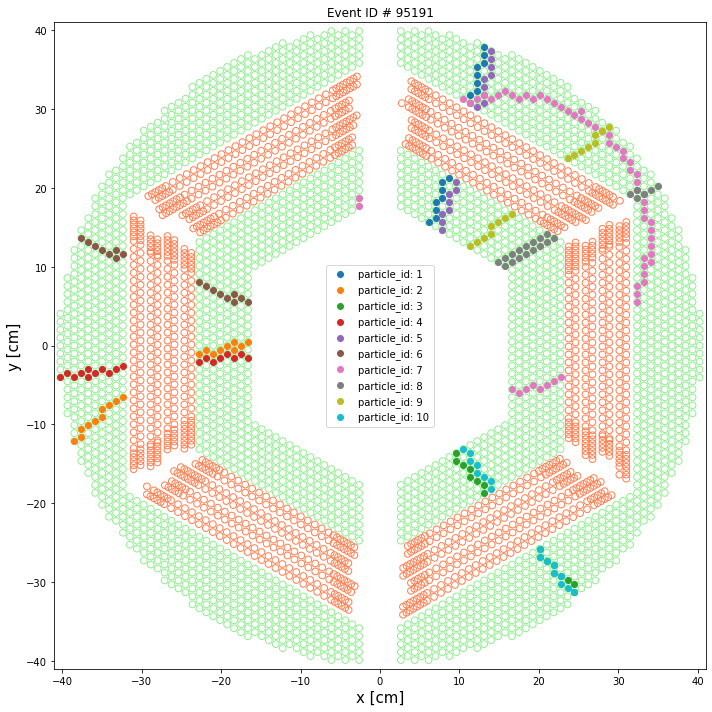

In [16]:
# compose event is exactly the same as select_hits()
event = Compose_Event(event_prefix, noise=False, skewed=False)
Draw_Compose_Event(event,figsize=(10,10));

## _True Edges_

**True Graph** is the ground truth for GNN. It is built from creating edges from _`hits`_ from the same particle but in adjacent layers. For this purpose one has _`true_edges, hits = get_layerwise_edges(event)`_ function in the _`event_util.py`_.

### _1. Layerwise True Edges_

In [17]:
from LightningModules.Processing.utils.event_utils import select_hits
from LightningModules.Processing.utils.event_utils import get_layerwise_edges

In [18]:
# select hits
hits = select_hits(event_file=event_prefix, noise=False, skewed=False)

In [19]:
# layerwise true edges & new hits dataframe
true_edges, hits = get_layerwise_edges(hits)

In [20]:
# true_edges

In [21]:
# split as sender and recivers
senders, receivers = true_edges

In [22]:
# gives True
# senders == true_edges[0]

In [23]:
# gives True
# receivers  == true_edges[1]

### _Plotting Layerwise True Edges_

- I have hit pairs in two arrays
- Extract each pair (w/ `hit_id`) to plot
- How to plot hit pairs for one track?

In [24]:
# lets get unique pids with freq (~ hits).
sel_pids, sel_pids_fr = np.unique(hits.particle_id, return_counts=True)
print(sel_pids)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [25]:
# check size of true_edges
size = true_edges.shape[1]
print(size)

465


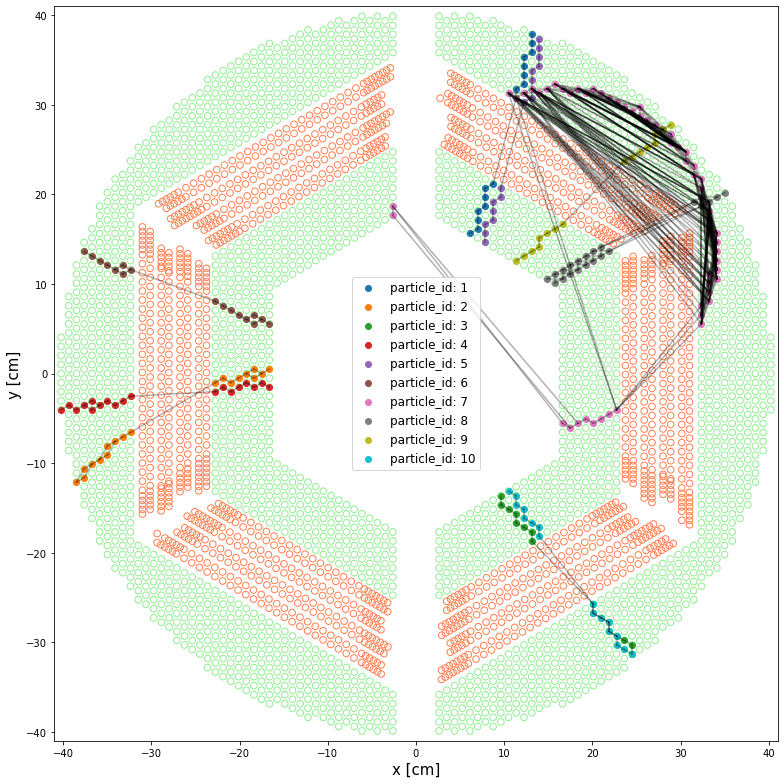

In [26]:
# New: Plotting true_edges
fig, ax = detector_layout(figsize=(11,11))

# particle tracks
for pid in sel_pids:
    idx = hits.particle_id == pid
    ax.scatter(hits[idx].x.values, hits[idx].y.values, label='particle_id: %d' %pid)
    
# true edges
for iedge in range(true_edges.shape[1]):
    pt1 = hits.iloc[true_edges[0][iedge]]
    pt2 = hits.iloc[true_edges[1][iedge]]
    ax.plot([pt1.x, pt2.x], [pt1.y, pt2.y], color='k', alpha=0.3, lw=1.5)

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
fig.savefig("layerwise_true_edges.pdf")

- eda of **_get_layerwise_edges(event)_** function

In [27]:
# Sort by increasing distance from production
hits = hits.assign(
        R=np.sqrt(
            (hits.x - hits.vx) ** 2 + (hits.y - hits.vy) ** 2 + (hits.z - hits.vz) ** 2
        )
    )

In [28]:
# re-indexing of hits dataframe, we get two extra columns: R and index
hits = hits.sort_values("R").reset_index(drop=True).reset_index(drop=False)

In [29]:
# assign particle_id=0 as NaN
hits.loc[hits["particle_id"] == 0, "particle_id"] = np.nan

In [30]:
hits.head()

,level_0,index,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,...,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id,R
0,0,0,261,-16.618999,0.505,35.0,9,0,26,0.109869,...,-0.020538,0.254955,1.0,2.0,0.0,0.0,0.0,0.116506,95191,38.748497
1,1,1,184,7.872170,14.645,35.0,9,0,98,0.377863,...,0.298670,0.096087,1.0,5.0,0.0,0.0,0.0,0.323485,95191,38.748512
2,2,2,209,-16.618999,-1.515,35.0,9,0,28,0.386065,...,-0.100413,0.376440,1.0,4.0,0.0,0.0,0.0,1.092913,95191,38.774815
3,3,3,236,9.621540,-13.635,35.0,9,0,61,0.130820,...,-0.410780,0.649517,1.0,3.0,0.0,0.0,0.0,0.518107,95191,38.774830
4,4,4,1,10.496200,-13.130,35.0,9,0,62,0.017837,...,-1.113330,-0.235016,1.0,10.0,0.0,0.0,0.0,1.409858,95191,38.827400


In [31]:
# hit_list based on particle_id and layer_id
hit_list = (
        hits.groupby(["particle_id", "layer_id"], sort=False)["index"]
        .agg(lambda x: list(x))
        .groupby(level=0)
        .agg(lambda x: list(x))
    )

In [32]:
hit_list

particle_id
1.0     [[5], [13], [26], [38], [49], [59], [69], [80]...
2.0     [[0], [7], [18, 19], [32], [43], [54], [65], [...
3.0     [[3], [11], [20], [36], [44], [55], [68], [79]...
4.0     [[2], [10], [21], [35], [47], [57], [66], [77]...
5.0     [[1], [12], [22], [34], [45], [56], [67], [78]...
6.0     [[9], [24], [31, 39], [46], [58], [71], [83], ...
7.0     [[8, 15], [23, 28], [30], [41], [53], [63], [7...
8.0     [[17, 27], [33, 40], [48, 52], [61, 64], [72, ...
9.0     [[6], [16], [29], [42], [51], [62], [74], [85]...
10.0    [[4], [14], [25], [37], [50], [60], [70], [81]...
Name: index, dtype: object

In [33]:
# get first row of hit list i.e. first particle
# row = hit_list.values[0]

In [34]:
# get elements of array from 0 to n-1 i.e. skipping the last element
# row[0:-1]

In [35]:
# get elements of array from 1 to n i.e. skipping the first elemnet
# row[1:]

In [36]:
# now build layerwise true edges
true_edges = []
for row in hit_list.values:
    for i, j in zip(row[0:-1], row[1:]): # row is list: we take 0 to n-1 elements as row[0:-1], and 1 to n as row[1:]
        true_edges.extend(list(itertools.product(i, j))) # extend() will add an iterable (list, set, etc) to the end of true_edges list, append() add one element to end of list.

In [37]:
true_edges = np.array(true_edges).T

* Now we have `true_edges` and corresponding `hits` (changed i.e. sorted due to `R` parameter.)

In [38]:
# lets see how to access true_edges, 2D ndarray
# true_edges

In [39]:
true_edges[0].size, true_edges[1].size

(465, 465)

- How to build edges based on some Euclidean distance

In [40]:
# Euclidean Distance of Two Hits to get a better true graph
def distance (hits, i, j):
    """Hits dataframe containing all variables. i,j are two hit ids"""
    x1 = hits.loc[hits['hit_id'] == i].x.values
    y1 = hits.loc[hits['hit_id'] == i].y.values
    x2 = hits.loc[hits['hit_id'] == j].x.values
    y2 = hits.loc[hits['hit_id'] == j].y.values
    print(x1,y1,x2,y2)
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return d

In [41]:
# get one edge
e = 0

In [42]:
edge = senders[e], receivers[e]

In [43]:
edge

(5, 13)

In [44]:
# find hit_id=5
hits.loc[hits['hit_id'] == edge[0]]

,level_0,index,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,...,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id,R
50,50,50,5,12.2456,-16.16,35.0,9,4,528,0.490562,...,-1.12009,-0.235611,1.0,10.0,0.0,0.0,0.0,1.409587,95191,40.448738


In [45]:
# find 
hits.loc[hits['hit_id'] == edge[1]]

,level_0,index,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,...,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id,R


### _2. Modulewise True Edges_

In [46]:
from LightningModules.Processing.utils.event_utils import select_hits
from LightningModules.Processing.utils.event_utils import get_modulewise_edges

In [47]:
# select hits
hits = select_hits(event_file=event_prefix, noise=False, skewed=False)

In [48]:
# modulewise true edges
true_edges = get_modulewise_edges (hits)

In [49]:
# true_edges

In [50]:
# split as sender and recivers
senders, receivers = true_edges

In [51]:
# gives True
# senders == true_edges[0]

In [52]:
# gives True
# receivers  == true_edges[1]

### _Plotting Modulewise True Edges_

- I have hit pairs in two arrays
- Extract each pair (w/ `hit_id`) to plot
- How to plot hit pairs for one track?

In [53]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [54]:
# lets get unique pids with freq (~ hits).
sel_pids, sel_pids_fr = np.unique(hits.particle_id, return_counts=True)
print(sel_pids)

[ 1  2  3  4  5  6  7  8  9 10]


In [55]:
# check size of true_edges
size = true_edges.shape[1]
print(size)

210


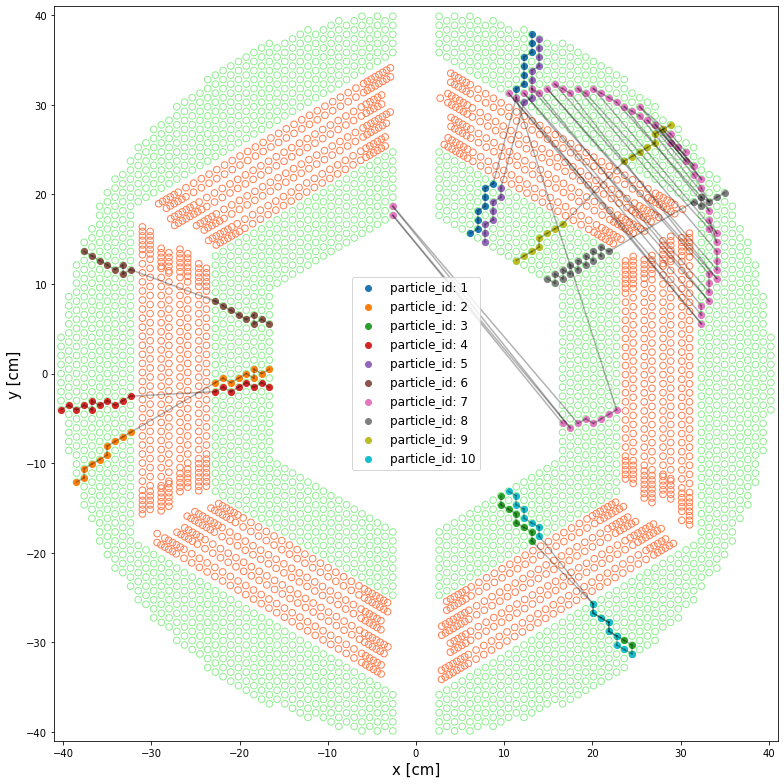

In [56]:
# New: Plotting true_edges
fig, ax = detector_layout(figsize=(11,11))

# particle tracks
for pid in sel_pids:
    idx = hits.particle_id == pid
    ax.scatter(hits[idx].x.values, hits[idx].y.values, label='particle_id: %d' %pid)
    
# true edges
for iedge in range(true_edges.shape[1]):
    pt1 = hits.iloc[true_edges[0][iedge]]
    pt2 = hits.iloc[true_edges[1][iedge]]
    ax.plot([pt1.x, pt2.x], [pt1.y, pt2.y], color='k', alpha=0.3, lw=1.5)

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
fig.savefig("modulewise_true_edges.pdf")

- eda of **_get_modulewise_edges(event)_** function

In [57]:
signal = hits[
        ((~hits.particle_id.isna()) & (hits.particle_id != 0)) & (~hits.vx.isna())
    ]

In [58]:
signal.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,sector_id,...,tpx,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id
0,1,10.49620,-13.130000,35.0,9,0,62,0.017837,0,3,...,0.864984,-1.113330,-0.235016,1.0,10,0.0,0.0,0.0,1.409858,95191
1,26,11.37090,12.625000,35.0,9,0,94,0.459918,0,5,...,0.557364,0.546427,-0.520368,1.0,9,0.0,0.0,0.0,0.780536,95191
2,50,14.86970,10.605000,35.0,9,0,90,0.444543,0,5,...,0.393970,0.237666,-0.387929,1.0,8,0.0,0.0,0.0,0.460106,95191
3,51,15.74430,10.100000,35.0,9,0,89,0.420698,0,5,...,0.394813,0.236153,-0.387954,1.0,8,0.0,0.0,0.0,0.460050,95191
4,81,-2.62406,17.674999,35.0,9,0,1,0.093095,0,0,...,0.015932,0.062116,0.057294,1.0,7,0.0,0.0,0.0,0.064126,95191


In [59]:
signal = signal.drop_duplicates(
        subset=["particle_id", "volume_id", "layer_id", "module_id"]
    )

In [60]:
signal.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,sector_id,...,tpx,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id
0,1,10.49620,-13.130000,35.0,9,0,62,0.017837,0,3,...,0.864984,-1.113330,-0.235016,1.0,10,0.0,0.0,0.0,1.409858,95191
1,26,11.37090,12.625000,35.0,9,0,94,0.459918,0,5,...,0.557364,0.546427,-0.520368,1.0,9,0.0,0.0,0.0,0.780536,95191
2,50,14.86970,10.605000,35.0,9,0,90,0.444543,0,5,...,0.393970,0.237666,-0.387929,1.0,8,0.0,0.0,0.0,0.460106,95191
3,51,15.74430,10.100000,35.0,9,0,89,0.420698,0,5,...,0.394813,0.236153,-0.387954,1.0,8,0.0,0.0,0.0,0.460050,95191
4,81,-2.62406,17.674999,35.0,9,0,1,0.093095,0,0,...,0.015932,0.062116,0.057294,1.0,7,0.0,0.0,0.0,0.064126,95191


In [61]:
# Sort by increasing distance from production
signal = signal.assign(
    R=np.sqrt(
        (signal.x - signal.vx) ** 2
        + (signal.y - signal.vy) ** 2
        + (signal.z - signal.vz) ** 2
    )
)

In [62]:
signal.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,sector_id,...,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id,R
0,1,10.49620,-13.130000,35.0,9,0,62,0.017837,0,3,...,-1.113330,-0.235016,1.0,10,0.0,0.0,0.0,1.409858,95191,38.827400
1,26,11.37090,12.625000,35.0,9,0,94,0.459918,0,5,...,0.546427,-0.520368,1.0,9,0.0,0.0,0.0,0.780536,95191,38.906143
2,50,14.86970,10.605000,35.0,9,0,90,0.444543,0,5,...,0.237666,-0.387929,1.0,8,0.0,0.0,0.0,0.460106,95191,39.478779
3,51,15.74430,10.100000,35.0,9,0,89,0.420698,0,5,...,0.236153,-0.387954,1.0,8,0.0,0.0,0.0,0.460050,95191,39.684921
4,81,-2.62406,17.674999,35.0,9,0,1,0.093095,0,0,...,0.062116,0.057294,1.0,7,0.0,0.0,0.0,0.064126,95191,39.297470


In [63]:
signal = signal.sort_values("R").reset_index(drop=False)

In [64]:
# Handle re-indexing
signal = signal.rename(columns={"index": "unsorted_index"}).reset_index(drop=False)
signal.loc[signal["particle_id"] == 0, "particle_id"] = np.nan

In [65]:
# Group by particle ID
signal_list = signal.groupby(["particle_id"], sort=False)["index"].agg(
    lambda x: list(x)
)

In [66]:
true_edges = []
for row in signal_list.values:
    for i, j in zip(row[:-1], row[1:]):
        true_edges.append([i, j])

In [67]:
true_edges = np.array(true_edges).T

In [68]:
true_edges = signal.unsorted_index.values[true_edges]

In [69]:
# split as sender and recivers
senders, receivers = true_edges

In [70]:
# get one edge
e = 0

In [71]:
edge = senders[e], receivers[e]

In [72]:
edge

(10, 22)

In [73]:
# find first node
hits.loc[hits['hit_id'] == edge[0]]

,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,sector_id,...,tpx,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id


In [74]:
# find second node
hits.loc[hits['hit_id'] == edge[1]]

,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,sector_id,...,tpx,tpy,tpz,weight,particle_id,vx,vy,vz,pt,event_id
172,22,22.7418,-29.290001,35.0,9,21,3973,0.196033,0,3,...,0.8147,-1.14994,-0.235024,1.0,10,0.0,0.0,0.0,1.40929,95191


In [75]:
distance(hits, edge[0], edge[1])

[] [] [22.7418] [-29.29]


array([], dtype=float32)